In [28]:
import numpy as np
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import json
import pydde as dde
import os

########################################
#PARAMETERS
nTimeSteps = 60; #seconds
use_case = 'qhold'
timestamp = '1024'
samplenum = 15000
input_size = 9
# criterion = nn.SmoothL1Loss()  # Huber Loss
# criterion = nn.L1Loss(reduction = 'sum') 
criterion = torch.nn.MSELoss(reduction = 'sum')
if samplenum == 15000:
    model_file_path_active = '../Trained_Models/state_dict/Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_latest.pt'
    model_file_path_passive = '../Trained_Models/state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest.pt'
else:
    model_file_path_active = '../Trained_Models/state_dict/Model_statedict_active_' + use_case + f'_{nTimeSteps}tsteps_latest_{samplenum}.pt'
    model_file_path_passive = '../Trained_Models/state_dict/Model_statedict_passive_' + use_case + f'_{nTimeSteps}tsteps_latest_{samplenum}.pt'
sample_file_path = f'../Data/Samples/data_'+ use_case + f'_{nTimeSteps}tsteps_'+ timestamp +'/'
simulation_file_path = '../Data/Simulations/pm_target.sim'
objective_file_path = f'../Data/Objectives/pm_qhold.obj'
#print(os.listdir(sample_file_path))

# set log level
dde.set_log_level(dde.LogLevel.off)

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0
state_init = dyn.q(p_init)
r = dyn.r(state_init, p_init)
dr = dyn.dr_dp(state_init, p_init)
dq = dyn.dq_dp(state_init, p_init)

#########################################
#LOAD ORIGINAL SAMPLES
og_number_of_files = len(os.listdir(sample_file_path))-5
with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q'])
og_samplenum = filesize*og_number_of_files
og_input = np.zeros((og_samplenum, input_size))
og_loss = np.zeros(og_samplenum)
og_iterations = np.zeros(og_samplenum)
og_lineSearchIterations = np.zeros(og_samplenum)

for filenum in range(og_number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        for i, q_i in enumerate(data['q']):
            og_input[filenum*filesize+i, 0:3] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            og_input[filenum*filesize+i, 3:6] = np.array(qdot_i)
        for i, p_now_i in enumerate(data['p_now']):
            og_input[filenum*filesize+i, 6:9] = np.array(p_now_i)
        for i, truth in enumerate(data['loss']):
            og_loss[filenum*filesize+i] = np.array(truth)
        for i, iter_ in enumerate(data['iterations']):
            og_iterations[filenum*filesize+i] = np.array(iter_)
        for i, line in enumerate(data['lineSearchIterations']):
            og_lineSearchIterations[filenum*filesize+i] = np.array(line+1)


#########################################
#LOAD TEST SAMPLES
number_of_files = len(os.listdir(sample_file_path + 'data_test/'))
with open(sample_file_path+ 'data_test/' + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q'])
samplenum_ = filesize*number_of_files
p = np.zeros((samplenum_, dyn.nParameters*nTimeSteps))
input = np.zeros((samplenum_, input_size))
loss = np.zeros(samplenum_)
iterations = np.zeros(samplenum_)
lineSearchIterations = np.zeros(samplenum_)

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_test/data_{filenum}.json') as json_file:
        data_ = json.load(json_file)
        for i, p_i in enumerate(data['p']):
            p[filenum*filesize+i, :] = np.array(p_i)
        for i, q_i in enumerate(data_['q']):
            input[filenum*filesize+i, 0:3] = np.array(q_i)
        for i, qdot_i in enumerate(data_['qdot']):
            input[filenum*filesize+i, 3:6] = np.array(qdot_i)
        for i, p_now_i in enumerate(data_['p_now']):
            input[filenum*filesize+i, 6:9] = np.array(p_now_i) - input[filenum*filesize+i, 0:3]
        for i, truth in enumerate(data_['loss']):
            loss[filenum*filesize+i] = np.array(truth)
        for i, iter_ in enumerate(data_['iterations']):
            iterations[filenum*filesize+i] = np.array(iter_)
        for i, line in enumerate(data_['lineSearchIterations']):
            lineSearchIterations[filenum*filesize+i] = np.array(line+1)

        output_size = len(data['p'][0])

print(f'input_size: {input_size}, output_size: {output_size}')
print(f'Shape of og_input: {og_input.shape}')
print(f'Shape of input: {input.shape}')

#Remove zeros
p = p[~(input == 0).all(1)]
og_input = og_input[~(og_input == 0).all(1)]
input = input[~(input == 0).all(1)]

print(f'og_input after removing zeros: {og_input.shape}')
print(f'input after removing zeros: {input.shape}')

data = torch.tensor(input).float()
og_data = torch.tensor(og_input).float()

################################
#LOAD MODEL
activeHiddenlayers = [180, 200]
class ActiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(ActiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, activeHiddenlayers[0])
        self.H1 = nn.Linear(activeHiddenlayers[0], activeHiddenlayers[1])
        #self.H1 = nn.Linear(activeHiddenlayers[0], out_sz)
        self.H2 = nn.Linear(activeHiddenlayers[1], out_sz)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)

    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.H2(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x

passiveHiddenlayers = [180, 200]
class PassiveLearn(nn.Module):

    def __init__(self, n_in, out_sz):
        super(PassiveLearn, self).__init__()

        self.L_in = nn.Linear(n_in, passiveHiddenlayers[0])
        self.H1 = nn.Linear(passiveHiddenlayers[0], passiveHiddenlayers[1])
        self.H2 = nn.Linear(passiveHiddenlayers[1], out_sz)
        self.L_out = nn.Linear(out_sz, out_sz)
        self.Relu = nn.ReLU(inplace=True)

    
    def forward(self, input):
        x = self.L_in(input)
        x = self.Relu(x)
        x = self.H1(x)
        x = self.Relu(x)
        x = self.H2(x)
        x = self.Relu(x)
        x = self.L_out(x)
        return x


active_model = ActiveLearn(input_size, output_size)
passive_model = PassiveLearn(input_size, output_size)
active_model.load_state_dict(torch.load(model_file_path_active))
passive_model.load_state_dict(torch.load(model_file_path_passive))
print("MODELS LOADED")

input_size: 9, output_size: 180
Shape of og_input: (15000, 9)
Shape of input: (5000, 9)
og_input after removing zeros: (15000, 9)
input after removing zeros: (5000, 9)
MODELS LOADED


In [2]:
#########################################
# METADATA
#TRAINING DATA
og_original_loss = np.mean(og_loss)
og_lineiter = sum(og_lineSearchIterations)
og_newtoniter = sum(og_iterations)
print("TRAINING DATA")
print(f'mean original loss: {og_original_loss}')
print(f'total iterations: {og_lineiter+og_newtoniter}')
print(f'lineSearchIterations: {og_lineiter}')
print(f'Newton iterations: {og_newtoniter}')

#TEST DATA
original_loss = np.mean(loss)
lineiter = sum(lineSearchIterations)
newtoniter = sum(iterations)
print('\n')
print("TEST DATA")
print(f'mean original loss: {original_loss}')
print(f'total iterations: {lineiter+newtoniter}')
print(f'lineSearchIterations: {lineiter}')
print(f'Newton iterations: {newtoniter}')
print('\n')
iter_per_sample= ((og_lineiter+og_newtoniter)/og_samplenum + (lineiter+newtoniter)/samplenum)/2
print(f'Mean iterations per sample: {iter_per_sample}')

TRAINING DATA
mean original loss: 0.6972751861011628
total iterations: 289026.0
lineSearchIterations: 15498.0
Newton iterations: 273528.0


TEST DATA
mean original loss: 0.702541986611331
total iterations: 97197.0
lineSearchIterations: 5138.0
Newton iterations: 92059.0


Mean iterations per sample: 19.3539


In [25]:
#########################################
# TEST PARAMETERS
q_truth = np.zeros((samplenum, dyn.nDofs*nTimeSteps))
for i in range(samplenum):
    for k in range(nTimeSteps):
	    q_truth[i, k*dyn.nDofs : (k+1)*dyn.nDofs] = input[i, 0:3]
q_truth = torch.tensor(q_truth)
#########################################
# RUN DATA THROUGH MODEL
a_losses_qdot= []
a_losses_p_smoothness= []
a_losses_total= []
a_losses_p_start= []
a_losses_qdot_per_tstep= np.zeros((samplenum, nTimeSteps-1))

p_losses_qdot= []
p_losses_p_smoothness= []
p_losses_total= []
p_losses_p_start= []
p_losses_qdot_per_tstep= np.zeros((samplenum, nTimeSteps-1))


with torch.no_grad():
    for i in range(samplenum):
        dyn.q0 = data[i, 0:3]
        dyn.qdot0 = data[i, 3:6]
        dyn.p0 = data[i, 6:9] + data[i, 0:3]
        #passive model eval
        p_val_passive = passive_model(data[i, :])
        state = dyn.q(p_val_passive)
        q_traj = torch.tensor(state.q)
        loss_qdot_per_tstep = np.zeros(nTimeSteps-1)
        for t in range(nTimeSteps-1):
            loss_qdot_per_tstep[t] = criterion(q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs], q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])
        loss_p_start = criterion(p_val_passive[0:dyn.nParameters], data[i,6:9] + data[i, 0:3])
        loss_qdot = criterion(q_traj[0:dyn.nDofs*(nTimeSteps-1)], q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        loss_p_smoothness = criterion(p_val_passive[0:dyn.nParameters*(nTimeSteps-1)], p_val_passive[dyn.nParameters:dyn.nParameters*nTimeSteps])
        #for t in range(nTimeSteps-1):
        #    loss_qdot_per_tstep[t] = sum((q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs] - q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])**2)
        #loss_p_start = sum((p_val_passive[0:dyn.nParameters] - data[i,6:9] + data[i, 0:3])**2)
        #loss_qdot = sum((q_traj[0:dyn.nDofs*(nTimeSteps-1)] - q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])**2)
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        #loss_p_smoothness = sum((p_val_passive[0:dyn.nParameters*(nTimeSteps-1)] - p_val_passive[dyn.nParameters:dyn.nParameters*nTimeSteps])**2)
        p_losses_qdot_per_tstep[i, :] = loss_qdot_per_tstep
        p_losses_p_start.append(loss_p_start)
        p_losses_qdot.append(loss_qdot)
        p_losses_p_smoothness.append(loss_p_smoothness)
        p_losses_total.append((loss_qdot + loss_p_smoothness + loss_p_start))

        #active model eval
        p_val_active = active_model(data[i, :])
        state = dyn.q(p_val_active)
        q_traj = torch.tensor(state.q)
        loss_qdot_per_tstep = np.zeros(nTimeSteps-1)
        for t in range(nTimeSteps-1):
            loss_qdot_per_tstep[t] = criterion(q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs], q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])
        loss_p_start = criterion(p_val_active[0:dyn.nParameters], data[i,6:9] + data[i, 0:3])
        loss_qdot = criterion(q_traj[0:dyn.nDofs*(nTimeSteps-1)], q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        loss_p_smoothness = criterion(p_val_active[0:dyn.nParameters*(nTimeSteps-1)], p_val_active[dyn.nParameters:dyn.nParameters*nTimeSteps])
        #for t in range(nTimeSteps-1):
        #    loss_qdot_per_tstep[t] = sum((q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs] - q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])**2)
        #loss_p_start = sum((p_val_active[0:dyn.nParameters] - data[i,6:9] + data[i, 0:3])**2)
        #loss_qdot = sum((q_traj[0:dyn.nDofs*(nTimeSteps-1)] - q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])**2)
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        #loss_p_smoothness = sum((p_val_active[0:dyn.nParameters*(nTimeSteps-1)] - p_val_active[dyn.nParameters:dyn.nParameters*nTimeSteps])**2)
        a_losses_qdot_per_tstep[i, :] = loss_qdot_per_tstep
        a_losses_p_start.append(loss_p_start)
        a_losses_qdot.append(loss_qdot)
        a_losses_p_smoothness.append(loss_p_smoothness)
        a_losses_total.append((loss_qdot + loss_p_smoothness + loss_p_start))

print("PASSIVE")
print(f'mean TOTAL passive loss: {np.mean(p_losses_total)}')
print(f'mean passive loss for Q_TARGET: {np.mean(p_losses_qdot)}')
print(f'mean passive loss for P_SMOOTHNESS: {np.mean(p_losses_p_smoothness)}')
print(f'mean passive loss for P_START: {np.mean(p_losses_p_start)}')

print("ACTIVE")
print(f'mean TOTAL active loss: {np.mean(a_losses_total)}')
print(f'mean active loss for Q_TARGET: {np.mean(a_losses_qdot)}')
print(f'mean active loss for P_SMOOTHNESS: {np.mean(a_losses_p_smoothness)}')
print(f'mean active loss for P_START: {np.mean(a_losses_p_start)}')

PASSIVE
mean TOTAL passive loss: 0.7709431071925864
mean passive loss for Q_TARGET: 0.0055817147525730046
mean passive loss for P_SMOOTHNESS: 0.7433797121047974
mean passive loss for P_START: 0.021981680765748024
ACTIVE
mean TOTAL active loss: 0.6806858381096283
mean active loss for Q_TARGET: 0.0038884281810499725
mean active loss for P_SMOOTHNESS: 0.4005185663700104
mean active loss for P_START: 0.27627888321876526


In [ ]:

PASSIVE
mean TOTAL passive loss: 0.7541519242146243
mean passive loss for Q_TARGET: 0.004908139787531467
mean passive loss for P_SMOOTHNESS: 0.7306559085845947
mean passive loss for P_START: 0.01858786679804325
ACTIVE
mean TOTAL active loss: 0.6388943308964921
mean active loss for Q_TARGET: 0.002345408474126696
mean active loss for P_SMOOTHNESS: 0.3826931118965149
mean active loss for P_START: 0.25385582447052

Results:<br/>
## MSE, reduction = sum

100:

mean total passive loss: 0.7939493254748715

mean total active loss: 0.7113918395379305


1000:

mean total passive loss: 0.7487496451301989

mean total active loss: 0.6591273624179301


10000:

mean total passive loss: 0.7511301883855048

mean total active loss: 0.6376084061457672

15k:

ean total passive loss: 0.74977905862686

mean total active loss: 0.6331527940985943

15k with manual loss criterion:

mean total passive loss: 4.873876173490829

mean total active loss: 5.35758860531045



<br/>

## Hubert, reduction = sum

1000:
mean total passive loss: 4.99753788350313

mean total active loss: 6.63030727735342

10000:<br/>
mean total passive loss: 4.471344043400011<br/>
mean total active loss: 5.377013725358675<br/>
<br/>
Hubert

## Hubert, reduction = mean


100:<br/>
mean total passive loss: 0.01877171728954551<br/>
mean total active loss: 0.011747902263559611<br/>
1000:<br/>
mean total passive loss: 0.011190645177176854<br/>
mean total active loss: 0.005570460007679607<br/>
10000:<br/>
mean total passive loss: 0.010323213816017309<br/>
mean total active loss: 0.005232377494963024<br/>
15k:<br/>
mean total passive loss: 0.010293749829700863<br/>
mean total active loss: 0.004982819350022914<br/>

## PLOTS

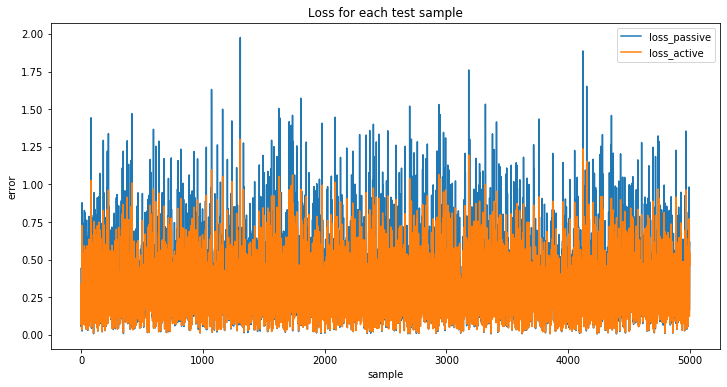

mean qdot passive: 0.004937580908165538
mean qdot active: 0.0023289141653650924


In [40]:

#########################################
# PLOT LOSS OF EACH SAMPLE
plt.figure(figsize = [12,6])
loss_passive = plt.plot(p_losses_total, label = 'loss_passive')
loss_active = plt.plot(a_losses_total, label = 'loss_active')
plt.legend()
plt.ylabel('error')
plt.xlabel('sample')
plt.title('Loss for each test sample')
plt.show()
a_loss = np.mean(a_losses_qdot)
p_loss = np.mean(p_losses_qdot)
print(f'mean qdot passive: {p_loss}')
print(f'mean qdot active: {a_loss}')

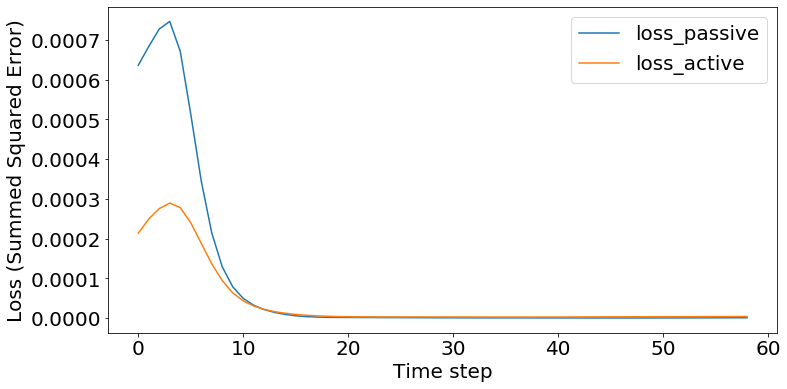

In [48]:
#########################################
# PLOT LOSS AT EACH TIMESTEP
a_mean_loss_per_tstep = np.zeros(nTimeSteps-1)
p_mean_loss_per_tstep = np.zeros(nTimeSteps-1)

for s in range(nTimeSteps-1):
    a_mean_loss_per_tstep[s] = sum(a_losses_qdot_per_tstep[:, s])/samplenum
    p_mean_loss_per_tstep[s] = sum(p_losses_qdot_per_tstep[:, s])/samplenum

plt.figure(figsize = [12,6])
loss_passive = plt.plot(p_mean_loss_per_tstep, label = 'loss_passive')
loss_active = plt.plot(a_mean_loss_per_tstep, label = 'loss_active')
plt.legend(prop={'size': 20})
plt.ylabel('Loss (Summed Squared Error)', fontsize=20)
plt.xlabel('Time step', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

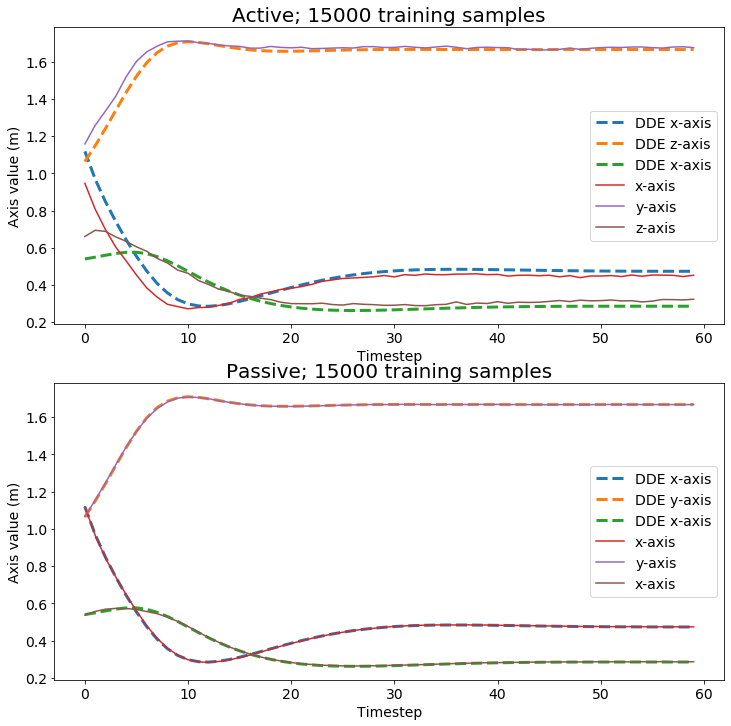

In [29]:
#########################################
# COMPARISON OF TRAJECTORIES

randomsample = 7
with torch.no_grad():
        p_valA = active_model(data[randomsample, :])
        p_valP = passive_model(data[randomsample, :])
        p_truth = p[randomsample,:]

        x_valA = p_valA[0::3]
        y_valA = p_valA[1::3]
        z_valA = p_valA[2::3]
        x_valP = p_valP[0::3]
        y_valP = p_valP[1::3]
        z_valP = p_valP[2::3]
        x_truth = p_truth[0::3]
        y_truth = p_truth[1::3]
        z_truth = p_truth[2::3]
            
plt.figure(figsize = [12,12])
plt.subplot(2, 1, 1)
#plt.title('Control trajectories from ACTIVE model and Trajectory Optimization')
plt.title(f'Active; {samplenum} training samples', fontsize = 20)

plt.plot(x_truth, '--', label = 'DDE x-axis', linewidth=3)
plt.plot(y_truth, '--', label = 'DDE z-axis', linewidth=3)
plt.plot(z_truth, '--', label = 'DDE x-axis', linewidth=3)

plt.plot(x_valA, label = 'x-axis')
plt.plot(y_valA, label = 'y-axis')
plt.plot(z_valA, label = 'z-axis')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Timestep', fontsize = 14)
plt.ylabel('Axis value (m)', fontsize = 14)
plt.legend(fontsize= 14)


plt.subplot(2, 1, 2)
#plt.title('Control trajectories from PASSIVE model and Trajectory Optimization')
plt.title(f'Passive; {samplenum} training samples', fontsize = 20)

plt.plot(x_truth, '--', label = 'DDE x-axis', linewidth=3)
plt.plot(y_truth, '--', label = 'DDE y-axis', linewidth=3)
plt.plot(z_truth, '--', label = 'DDE x-axis', linewidth=3)

plt.plot(x_valP, label = 'x-axis')
plt.plot(y_valP, label = 'y-axis')
plt.plot(z_valP, label = 'x-axis')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Timestep', fontsize = 14)
plt.ylabel('Axis value (m)', fontsize = 14)
plt.legend(fontsize= 14)


plt.show()

In [6]:
#########################################
# ROBUSTNESS

sample_file_path = f'../Data/Samples/data_'+ use_case + f'_{nTimeSteps}tsteps_robustness/'
samplenumRob = 5000

#########################################
#LOAD TEST SAMPLES
number_of_files = len(os.listdir(sample_file_path))-1
with open(sample_file_path + f'data_0.json') as json_file:
    data = json.load(json_file)
    filesize = len(data['q'])
samplenum = filesize*number_of_files
inputRob = np.zeros((samplenum, input_size))
loss = np.zeros(samplenum)
iterations = np.zeros(samplenum)
lineSearchIterations = np.zeros(samplenum)

for filenum in range(number_of_files):
    with open(sample_file_path + f'data_{filenum}.json') as json_file:
        data = json.load(json_file)
        for i, q_i in enumerate(data['q']):
            inputRob[filenum*filesize+i, 0:3] = np.array(q_i)
        for i, qdot_i in enumerate(data['qdot']):
            inputRob[filenum*filesize+i, 3:6] = np.array(qdot_i)
        for i, p_now_i in enumerate(data['p_now']):
            inputRob[filenum*filesize+i, 6:9] = np.array(p_now_i) - inputRob[filenum*filesize+i, 0:3]

        output_size = len(data['p'][0])

print(f'input_size: {input_size}, output_size: {output_size}')
print(f'Shape of inputRob: {inputRob.shape}')

#Remove zeros
inputRob = inputRob[~(inputRob == 0).all(1)]

print(f'inputRob after removing zeros: {inputRob.shape}')

data = torch.tensor(inputRob).float()

#########################################
# TEST PARAMETERS
q_truth = np.zeros((samplenum, dyn.nDofs*nTimeSteps))
for i in range(samplenum):
    for k in range(nTimeSteps):
	    q_truth[i, k*dyn.nDofs : (k+1)*dyn.nDofs] = inputRob[i, 0:3]
q_truth = torch.tensor(q_truth)

criterion = nn.MSELoss(reduction= 'sum')  # Huber Loss
#########################################
# RUN DATA THROUGH MODEL
a_losses_qdot= []
a_losses_p_smoothness= []
a_losses_total= []
a_losses_p_start= []
a_losses_qdot_per_tstep= np.zeros((samplenum, nTimeSteps-1))

p_losses_qdot= []
p_losses_p_smoothness= []
p_losses_total= []
p_losses_p_start= []
p_losses_qdot_per_tstep= np.zeros((samplenum, nTimeSteps-1))


with torch.no_grad():
    for i in range(samplenum):
        dyn.q0 = data[i, 0:3]
        dyn.qdot0 = data[i, 3:6]
        dyn.p0 = data[i, 6:9] + data[i, 0:3]
        #passive model eval
        p_val_passive = passive_model(data[i, :])
        state = dyn.q(p_val_passive)
        q_traj = torch.tensor(state.q)
        loss_qdot_per_tstep = np.zeros(nTimeSteps-1)
        for t in range(nTimeSteps-1):
            loss_qdot_per_tstep[t] = criterion(q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs], q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])
        loss_p_start = criterion(p_val_passive[0:dyn.nParameters], data[i,6:9] + data[i, 0:3])
        loss_qdot = criterion(q_traj[0:dyn.nDofs*(nTimeSteps-1)], q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])
        loss_qdot = criterion(q_traj, q_truth[i, :])
        loss_p_smoothness = criterion(p_val_passive[0:dyn.nParameters*(nTimeSteps-1)], p_val_passive[dyn.nParameters:dyn.nParameters*nTimeSteps])
        #for t in range(nTimeSteps-1):
        #    loss_qdot_per_tstep[t] = sum((q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs] - q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])**2)
        #loss_p_start = sum((p_val_passive[0:dyn.nParameters] - data[i,6:9] + data[i, 0:3])**2)
        #loss_qdot = sum((q_traj[0:dyn.nDofs*(nTimeSteps-1)] - q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])**2)
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        #loss_p_smoothness = sum((p_val_passive[0:dyn.nParameters*(nTimeSteps-1)] - p_val_passive[dyn.nParameters:dyn.nParameters*nTimeSteps])**2)
        p_losses_qdot_per_tstep[i, :] = loss_qdot_per_tstep
        p_losses_p_start.append(loss_p_start)
        p_losses_qdot.append(loss_qdot)
        p_losses_p_smoothness.append(loss_p_smoothness)
        p_losses_total.append((loss_qdot + loss_p_smoothness + loss_p_start))

        #active model eval
        p_val_active = active_model(data[i, :])
        state = dyn.q(p_val_active)
        q_traj = torch.tensor(state.q)
        loss_qdot_per_tstep = np.zeros(nTimeSteps-1)
        for t in range(nTimeSteps-1):
            loss_qdot_per_tstep[t] = criterion(q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs], q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])
        loss_p_start = criterion(p_val_active[0:dyn.nParameters], data[i,6:9] + data[i, 0:3])
        loss_qdot = criterion(q_traj[0:dyn.nDofs*(nTimeSteps-1)], q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        loss_p_smoothness = criterion(p_val_active[0:dyn.nParameters*(nTimeSteps-1)], p_val_active[dyn.nParameters:dyn.nParameters*nTimeSteps])
        #for t in range(nTimeSteps-1):
        #    loss_qdot_per_tstep[t] = sum((q_traj[t*dyn.nDofs:(t+1)*dyn.nDofs] - q_traj[(t+1)*dyn.nDofs:(t+2)*dyn.nDofs])**2)
        #loss_p_start = sum((p_val_active[0:dyn.nParameters] - data[i,6:9] + data[i, 0:3])**2)
        #loss_qdot = sum((q_traj[0:dyn.nDofs*(nTimeSteps-1)] - q_traj[dyn.nDofs:dyn.nDofs*nTimeSteps])**2)
        #loss_qdot = criterion(q_traj, q_truth[i, :])
        #loss_p_smoothness = sum((p_val_active[0:dyn.nParameters*(nTimeSteps-1)] - p_val_active[dyn.nParameters:dyn.nParameters*nTimeSteps])**2)
        a_losses_qdot_per_tstep[i, :] = loss_qdot_per_tstep
        a_losses_p_start.append(loss_p_start)
        a_losses_qdot.append(loss_qdot)
        a_losses_p_smoothness.append(loss_p_smoothness)
        a_losses_total.append((loss_qdot + loss_p_smoothness + loss_p_start))
print(f'mean total passive loss: {np.mean(p_losses_total)}')
print(f'mean total active loss: {np.mean(a_losses_total)}')

input_size: 9, output_size: 180
Shape of inputRob: (6000, 9)
inputRob after removing zeros: (6000, 9)
mean total passive loss: 8.622295621953347
mean total active loss: 1.4317322340754202
